In [78]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
import nltk
import preprocessor # preprocessing package for tweets
import re
import string
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import pickle
from sklearn.metrics import confusion_matrix, classification_report

In [77]:
# load the training data from train.csv
# label of 0 means negative and label of 1 means positive
train_data = pd.read_csv('train.csv', error_bad_lines=False, encoding='latin-1')
train_data.columns=['id', 'label', 'text']
train_data = train_data.drop('id', axis=1)
train_data.head()

,label,text
0,0,is so sad for my APL frie...
1,0,I missed the New Moon trail...
2,1,omg its already 7:30 :O
3,0,.. Omgaga. Im sooo im gunna CRy. I'...
4,0,i think mi bf is cheating on me!!! ...


In [3]:
# data exporation
# check the distribution of positive and negative sentences
negative = sum(train_data['label'] == 0)
positive = sum(train_data['label'] == 1)

print('Negative sentences: {}'.format(negative))
print('Positive sentences: {}'.format(positive))
print('Total sentences: {}'.format(len(train_data)))

Negative sentences: 43532
Positive sentences: 56457
Total sentences: 99989


In [4]:
# checking length of tweets
def get_text_length(text):
    return len(text.split())

train_data['text_length'] = train_data['text'].apply(get_text_length)
train_data.head()

,label,text,text_length
0,0,is so sad for my APL frie...,7
1,0,I missed the New Moon trail...,6
2,1,omg its already 7:30 :O,5
3,0,.. Omgaga. Im sooo im gunna CRy. I'...,25
4,0,i think mi bf is cheating on me!!! ...,9


<module 'matplotlib.pyplot' from '/Users/yangkevi/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

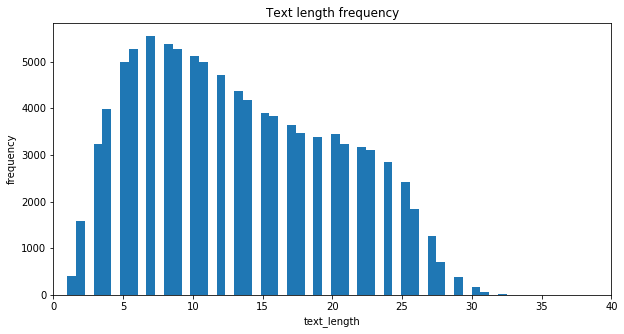

In [5]:
# distribution of words 
plt.figure(figsize=(10, 5))
plt.title('Text length frequency')
plt.xlabel('text_length')
plt.ylabel('frequency')
plt.xlim(0, 40)
plt.hist([train_data['text_length']], bins=200)
plt
# most tweets seem to be very short

In [6]:
# get common words in the data set, these are most likely stop words that we want to remove
# also get total number of unique words
unique_words = set()
all_words = []
for tweet in train_data['text']:
    words = tweet.split()
    for word in words:
        unique_words.add(word.lower())
        all_words.append(word.lower())

print('Unique words: {}'.format(len(unique_words)))
print('Total words: {}'.format(len(all_words)))
Counter(all_words).most_common(25)
# these common words don't add much meaning to each text so we will filter some out (using nltk stop words)

Unique words: 165473
Total words: 1330178


[('i', 48880),
 ('the', 29629),
 ('to', 29177),
 ('you', 23456),
 ('a', 21908),
 ('and', 15826),
 ('it', 14154),
 ('my', 13598),
 ('for', 12378),
 ('is', 11618),
 ('in', 11497),
 ('of', 10519),
 ('that', 10051),
 ('have', 9794),
 ('on', 9228),
 ('me', 8718),
 ('so', 8601),
 ('but', 8489),
 ("i'm", 8167),
 ('be', 7248),
 ('was', 7128),
 ('not', 6749),
 ('just', 6649),
 ('your', 6416),
 ('are', 5901)]

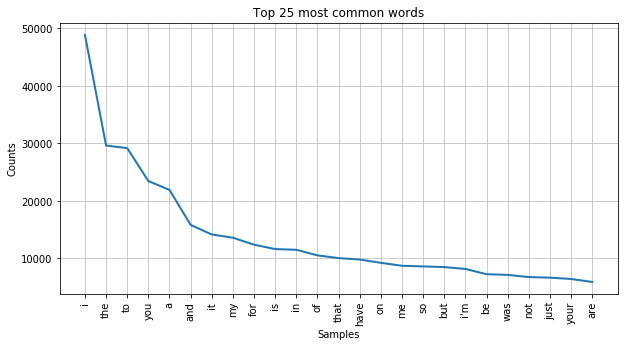

<module 'matplotlib.pyplot' from '/Users/yangkevi/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [7]:
# plot frequency of top 25 words
plt.figure(figsize=(10,5))
plt.title('Top 25 most common words')
nltk.FreqDist(all_words).plot(25, cumulative=False)
plt

In [10]:
# preprocess the tweet
porter = nltk.stem.porter.PorterStemmer()
def preprocess_tweet(tweet):
    # Remove URL, Emoji, Hashtag, etc
    tweet = preprocessor.clean(tweet)
    tweet = tweet.lower()
    # Remove whitespace
    tweet = re.sub(r'\s\s+', ' ', tweet)
    # Remove single space remaining at the front of the tweet.
    tweet = tweet.lstrip(' ') 
    # Remove characters beyond Unicode
    tweet = ''.join(c for c in tweet if c <= '\uFFFF') 
    # Convert to tokens
    tweet = nltk.tokenize.word_tokenize(tweet)
    # Remove Non Alphabetic words
    tweet = [word for word in tweet if word.isalpha()]
    # Remove stop words
    tweet = [word for word in tweet if word not in set(nltk.corpus.stopwords.words('english'))]
    # Stemming words
    tweet = [porter.stem(word) for word in tweet]
    return tweet
    

train_data['text'] = train_data['text'].apply(preprocess_tweet)
train_data = train_data.drop('text_length', axis=1)
train_data.head()

,label,text
0,0,"[sad, apl, friend]"
1,0,"[miss, new, moon, trailer]"
2,1,"[omg, alreadi]"
3,0,"[omgaga, im, sooo, im, gunna, cri, dentist, si..."
4,0,"[think, mi, bf, cheat]"


In [11]:
# remove empty text entries
train_data_filtered = train_data[train_data['text'].str.len() != 0]
train_data_filtered.head()

,label,text
0,0,"[sad, apl, friend]"
1,0,"[miss, new, moon, trailer]"
2,1,"[omg, alreadi]"
3,0,"[omgaga, im, sooo, im, gunna, cri, dentist, si..."
4,0,"[think, mi, bf, cheat]"


In [12]:
# looking at what words we have now after cleaning
unique_words_new = set()
all_words_new = []
for tweet in train_data['text']:
    all_words_new.extend(tweet)
    for word in tweet:
        unique_words_new.add(word)

print('Unique words: {}'.format(len(unique_words_new)))
print('Total words: {}'.format(len(all_words_new)))
Counter(all_words_new).most_common(25)
# new common words are good and add meaning to tweets

Unique words: 37068
Total words: 644903


[('quot', 8569),
 ('get', 6567),
 ('go', 6280),
 ('like', 5912),
 ('good', 5908),
 ('thank', 5721),
 ('love', 5438),
 ('lol', 5173),
 ('u', 5115),
 ('know', 4753),
 ('day', 4238),
 ('one', 3929),
 ('work', 3717),
 ('see', 3550),
 ('got', 3497),
 ('time', 3496),
 ('think', 3360),
 ('hope', 3242),
 ('amp', 3144),
 ('want', 3135),
 ('well', 3108),
 ('miss', 3085),
 ('oh', 2864),
 ('haha', 2811),
 ('im', 2808)]

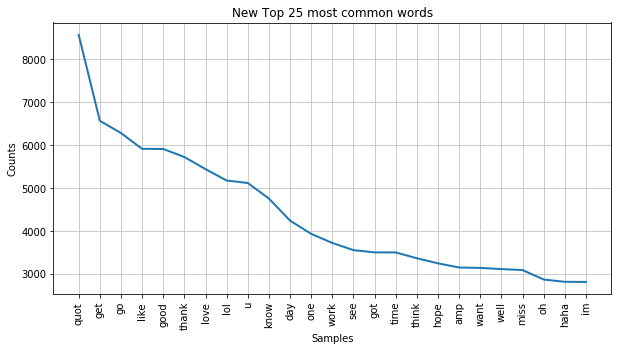

<module 'matplotlib.pyplot' from '/Users/yangkevi/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [13]:
# plot frequency of new top 25 words
plt.figure(figsize=(10,5))
plt.title('New Top 25 most common words')
nltk.FreqDist(all_words_new).plot(25, cumulative=False)
plt

In [14]:
# rejoin list of words into single word for training
def rejoin_tweet(tweet):
    return ' '.join(word for word in tweet)

train_data_filtered['text'] = train_data_filtered['text'].apply(rejoin_tweet)
train_data_filtered.head()

/Users/yangkevi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,label,text
0,0,sad apl friend
1,0,miss new moon trailer
2,1,omg alreadi
3,0,omgaga im sooo im gunna cri dentist sinc supos...
4,0,think mi bf cheat


In [105]:
# Now we can start vectorizing the text to train a classifier
# We can start with using one hot encoding since the tweets are very short
# Tfidf slightly outperforms one hot encoding

#vectorizer = CountVectorizer()
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(train_data_filtered['text'])
y = train_data_filtered['label']

len(vectorizer.vocabulary_)

37035

In [102]:
# Can try simple Logistic Regression for now

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=2)

lr = LogisticRegression(n_jobs=-1)
lr.fit(X_train, y_train)
lr

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=-1,
          penalty='l2', random_state=None, solver='warn', tol=0.0001,
          verbose=0, warm_start=False)

In [82]:
# save the model in case for future use

pickle.dump(lr, open("logistic_regression.p", 'wb'))

In [106]:
# now we can evaluate how well our model does

accuracy = lr.score(X_test, y_test)
accuracy

0.752

In [84]:
y_preds = lr.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_preds)
print('confusion matrix: ')
conf_matrix

confusion matrix: 


array([[2805, 1485],
       [ 964, 4621]])

In [85]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.74      0.65      0.70      4290
           1       0.76      0.83      0.79      5585

   micro avg       0.75      0.75      0.75      9875
   macro avg       0.75      0.74      0.74      9875
weighted avg       0.75      0.75      0.75      9875

